# Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

## Basic imports

In [31]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

## Exploring the dataset

In [32]:
!ls DL_Data_sets/Dogs_vs_cats
!ls DL_Data_sets/Dogs_vs_cats/training_set/cats/ | head
!ls DL_Data_sets/Dogs_vs_cats/training_set/dogs/ | head

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


(499, 336, 3)


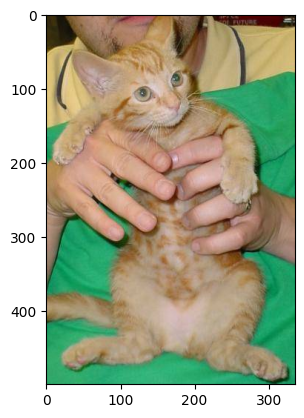

In [33]:
cat_image = cv2.imread('DL_Data_sets/Dogs_vs_cats/training_set/cats/cat.1001.jpg')
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)

print(cat_image.shape)
plt.imshow(cat_image)

In [34]:
!rm  /content/DL_Data_sets/Dogs_vs_cats/labels.csv

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [35]:
train_data_path = 'DL_Data_sets/Dogs_vs_cats/training_set'
test_data_path = 'DL_Data_sets/Dogs_vs_cats/test_set'

labels_file = 'DL_Data_sets/Dogs_vs_cats/labels.csv'

image_paths = []
classes = []

with open(labels_file, 'w', newline='') as file:

    writer = csv.writer(file)
    columns = ['image_path', 'class']
    writer.writerow(columns)

    for data_path in glob.glob(train_data_path + '/*/*', recursive=True):
        data_class = data_path.split('/')[-2]
        if not data_class in classes: classes.append(data_class)
        image_paths.append(data_path)
        writer.writerow([data_path, '0' if data_class == 'cats' else '1'])

classes.sort()
print(classes)
print(image_paths[-10:])
print(f'Training images: {len(image_paths)}')

['Dogs_vs_cats']
['DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.990.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.991.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.992.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.993.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.994.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.995.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.996.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.997.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.998.jpg', 'DL_Data_sets/Dogs_vs_cats/training_set\\dogs\\dog.999.jpg']
Training images: 8000


The following is a sample of the labels file:

In [36]:
!cat DL_Data_sets/Dogs_vs_cats/labels.csv | head
!cat DL_Data_sets/Dogs_vs_cats/labels.csv | tail

"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


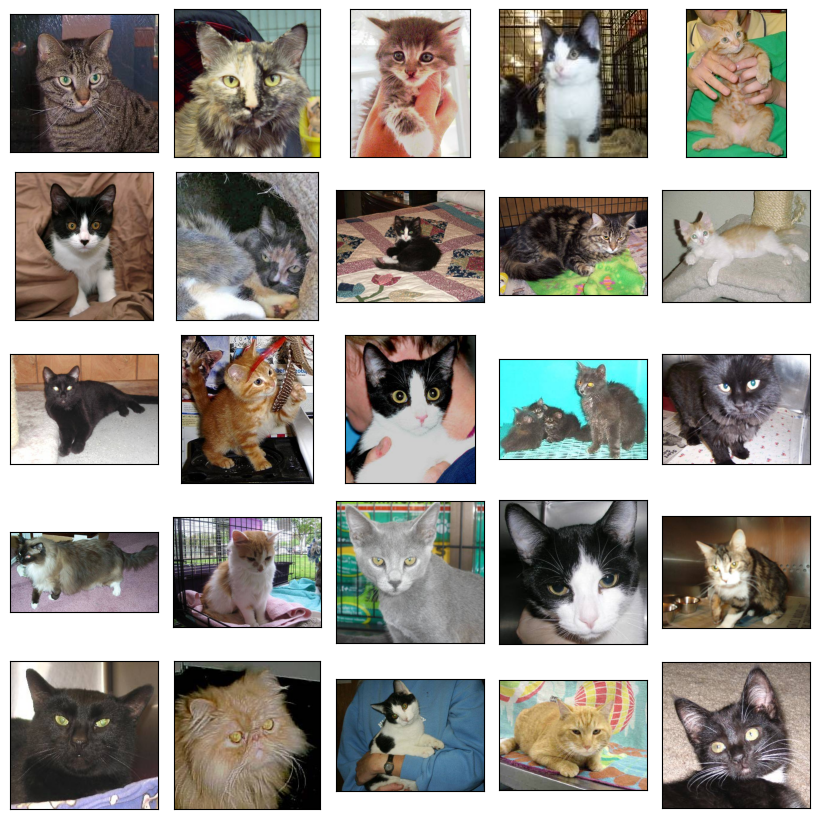

In [37]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=0.)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1,hspace=0.1)

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    cat_image = cv2.imread(image_paths[idx])
    cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)

    ax[row, col].imshow(cat_image)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

## Data preparation

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the images.
2. Resize the images.
3. Convert to tensors and normalize the data.
4. Pack them in batches.

We'll achieve these steps using torchvision.transforms, and the Imagefolder utilities.

First, we extract the classes into a dictionary in order to access the contents later.

In [38]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)
print(class_to_idx)

{0: 'Dogs_vs_cats'}
{'Dogs_vs_cats': 0}


### Transformations

Transformations in torchvision refer to a set of image processing operations that can be applied to input images during data loading and preprocessing. These transformations are commonly used in computer vision tasks, especially when working with deep learning models. They serve various purposes, including data augmentation, normalization, and image preprocessing. Here's an explanation of transformations in torchvision:

- Data Augmentation: Data augmentation is a technique used to artificially increase the diversity of the training dataset by applying random transformations to the input images. This helps improve the model's ability to generalize and reduces overfitting. Torchvision provides a range of data augmentation transformations such as:

    - RandomCrop: Crops the image randomly to a specified size.
    - RandomHorizontalFlip: Randomly flips the image horizontally with a given probability.
    - RandomRotation: Rotates the image by a random angle.
    - ColorJitter: Randomly changes the brightness, contrast, saturation, and hue of the image.
    - RandomAffine: Applies random affine transformations like translation, rotation, scaling, and shearing.
- Normalization: Normalization is the process of rescaling the pixel values of images to a standard range. It helps in stabilizing and accelerating the training process by ensuring that the input data has similar statistics. Torchvision provides normalization transformations like:
    - ToTensor: Converts the image from PIL format to a PyTorch tensor.
    - Normalize: Normalizes the tensor image by subtracting the mean and dividing by the standard deviation.

- Image Preprocessing: Image preprocessing transformations are used to prepare the images for input to the model. This includes resizing, converting color channels, or applying specific filters. Some common image preprocessing transformations in torchvision include:

    - Resize: Resizes the image to a specified size.
    - CenterCrop: Crops the image at the center to a specified size.
    - Grayscale: Converts the image to grayscale.
    - Pad: Pads the image with a specified padding value.
    - Combining Transformations: Torchvision provides the transforms.Compose class to combine multiple transformations into a single transformation pipeline. This allows you to apply a sequence of transformations to the input images in a specified order. For example:

```python
from torchvision import transforms

# Define individual transformations
transform1 = transforms.RandomCrop(size=224)
transform2 = transforms.RandomHorizontalFlip()
transform3 = transforms.ToTensor()

# Combine the transformations
transform = transforms.Compose([transform1, transform2, transform3])
```

- Applying Transformations: Transformations are typically applied during data loading using the transform parameter of the dataset class. For example, when using the ImageFolder dataset, you can pass the transformation pipeline as follows:

```pytorch
from torchvision import datasets, transforms

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and apply the transformations
dataset = datasets.ImageFolder(root="/path/to/images", transform=transform)
```




In [39]:
image_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

### Datasets and Dataloaders

The torch.utils.data module in PyTorch provides a set of utilities and classes to work with datasets and data loading. It includes the Dataset and DataLoader classes, which are fundamental components for efficiently loading and managing data in PyTorch. Here's a description and explanation of these classes:

- **torch.utils.data.Dataset**: The Dataset class represents a collection of data samples and their corresponding labels or targets. It is an abstract class, meaning that you need to subclass it and implement its methods to define your own custom dataset. The Dataset class is responsible for loading and preprocessing the data samples.

- **torch.utils.data.DataLoader**: The DataLoader class in PyTorch is used to create an iterable over a given dataset, enabling easy and efficient data loading. It provides functionality for batching, shuffling, and parallel data loading.

    - Purpose: The DataLoader class automates the process of loading data from a dataset and creating batches for training or evaluation.

    - Parameters: When creating a DataLoader, you need to provide the dataset object, along with optional parameters such as batch_size, shuffle, num_workers, etc. For example:

    - Batching: The DataLoader divides the dataset into mini-batches of a specified size (batch_size). This helps in efficiently training the model by processing multiple samples in parallel.

    - Shuffling: By setting shuffle=True, the DataLoader randomly shuffles the dataset before creating batches. This ensures that the model sees the data in a random order during training, improving generalization.

### Loading images

To load a dataset, you can create a custom Dataset class, or use the ImageFolder class that Pytorch provides. Here are examples of how to load a custom dataset with both aproaches.



#### Loading cats and dog images into a dataloader using the Dataset class

A custom Dataset class must implement three functions: \_\_init\_\_, \_\_len\_\_, and \_\_getitem\_\_. Take a look at this implementation; the files and their labels are stored separately in a CSV file annotations_file.

- \_\_init\_\_: The \_\_init\_\_ function is run once when instantiating the Dataset object. We initialize the the annotations file, and the image transforms.
- \_\_len\_\_: The \_\_len\__ function returns the number of samples in our dataset.
- \_\_getitem\_\_: The \_\_getitem\_\_ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the image and corresponding label in a tuple.

In [40]:
class CatsDogsDataset(Dataset):
    def __init__(self, annotations_file, classes, transform=None):
        self.labels_df = pd.read_csv(annotations_file)
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx, 0]
        image = Image.open(img_path)

        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [41]:
split_percentage = 0.8

train_image_count = int(len(image_paths) * split_percentage)
validation_image_count = len(image_paths) - train_image_count

print(f'Training images: {train_image_count} Validation images: {validation_image_count}')

Training images: 6400 Validation images: 1600


In [42]:
train_dataset = CatsDogsDataset(annotations_file=labels_file, classes=['cat', 'dog'], transform=image_transforms)
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_image_count, validation_image_count])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25)

print(f'Training dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')

print(f'Classes: {train_dataset.dataset.classes}')
print(f'Transform: {train_dataset.dataset.transform}')

Training dataset: 6400
Validation dataset: 1600
Classes: ['cat', 'dog']
Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


#### Loading cats and dog images into a dataloader using ImageFolder

The ImageFolder class in PyTorch's **torchvision.datasets** module provides a convenient way to load images and their corresponding target labels from a folder structure. It is commonly used for image classification tasks where images are organized into categories within folders. Here's a description and explanation of the ImageFolder imageloader:

- Folder Structure: The ImageFolder class expects a specific folder structure for the images. It assumes that the images are organized into categories, and each category has its own folder. The folders containing the images are typically placed inside a common root directory. For example, if you have images of cats and dogs, you would have a folder structure like root/cats and root/dogs.

- Instantiating ImageFolder: To create an instance of ImageFolder, you need to provide the root directory containing the categorized image folders. You can also specify optional arguments such as transform to apply transformations to the images during loading, and target_transform to apply transformations to the target labels.

- Loading Images and Labels: When you create an ImageFolder instance, it automatically scans the folder structure and loads the images and their corresponding target labels. The images are read from the files, and the target labels are inferred from the folder names. For example, if you have a folder named "cats," the images inside that folder will be associated with the label "cats."

- Accessing Data: The ImageFolder instance acts as a dataset, and you can access the loaded images and labels using indexing or iteration. Each sample in the dataset is a tuple containing the image (in tensor format) and its corresponding target label.

- Transformations: The transform parameter allows you to specify a list of transformations to be applied to the images during loading. This is useful for data augmentation, normalization, or any other desired image processing. For example, you can apply random crops, flips, or adjustments to the image data.

In [43]:
split_percentage = 0.8

train_image_count = int(len(image_paths) * split_percentage)
validation_image_count = len(image_paths) - train_image_count

In [44]:
train_dataset = ImageFolder(root='DL_Data_sets/Dogs_vs_cats/training_set', transform=image_transforms)
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_image_count, validation_image_count])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25)

print(f'Training dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')

print(f'Classes: {train_dataset.dataset.classes}')
print(f'Transform: {train_dataset.dataset.transform}')

Training dataset: 6400
Validation dataset: 1600
Classes: ['cats', 'dogs']
Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [45]:
print(train_dataset.dataset.samples)

[('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.10.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.100.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1000.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1001.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1002.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1003.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1004.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1005.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1006.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1007.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1008.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1009.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.101.jpg', 0), ('DL_Data_sets/Dogs_vs_cats/training_set\\cats\\cat.1010.jpg', 0), (

In [46]:
test_dataset = ImageFolder(root='DL_Data_sets/Dogs_vs_cats/test_set', transform=image_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

print(f'Test dataset: {len(test_dataset)}')
print(f'Classes: {test_dataset.classes}')
print(f'Transform: {test_dataset.transform}')

Test dataset: 2000
Classes: ['cats', 'dogs']
Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


#### Visualizing a batch

The "images" in the batch were transformed to tensors. Before we can plot them usint matplotlib, we need to convert them to images.

We first need to convert the tensors to numpy arrays, and then arrange the elements of the array to match the structure of an image. We use **transpose** and vector operations to achieve that.

The transpose function in NumPy is used to rearrange the dimensions of a numpy array. It takes an array as input and returns a new array with the axes transposed according to the specified permutation.

The parameters of the transpose function are:

1. a: This is the input numpy array that you want to transpose.
2. axes: This parameter is optional. It specifies how the axes of the input array should be permuted. It should be a tuple or list of integers indicating the new order of the axes. If axes is not provided, the function will perform a regular matrix transpose for 2D arrays and reverse the order of axes for N-dimensional arrays.

Now, let's understand the values 1, 2, 0 in the context of the transpose operation:

- 1: This refers to the second axis of the original array. In your case, it corresponds to the height of the image.
- 2: This refers to the third axis of the original array. In your case, it corresponds to the width of the image.
- 0: This refers to the first axis of the original array. In your case, it corresponds to the color channels of the image.

So, when you do image.transpose((1, 2, 0)), you are telling NumPy to create a new array where the height dimension becomes the first axis, the width dimension becomes the second axis, and the color channel dimension becomes the third axis. This effectively swaps the height and width dimensions with the color channel dimension.

In [47]:
train_batch = next(iter(train_dataloader))

print(train_batch[0].shape)
print(train_batch[1])

torch.Size([25, 3, 128, 128])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1])


In [48]:
# # Create a 5x5 subplot figure
# f, ax = plt.subplots(5, 5, figsize=(10, 10))
# # Adjust the layout of the subplots to avoid overlapping
# f.tight_layout(pad=0.)

# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

# # Iterate over the first 25 test images
# for idx in range(25):
#     # Calculate the row and column index for the subplot
#     row = idx // 5
#     col = idx % 5

#     image = train_batch[0][idx].numpy()
#     # image = np.reshape(image, (150, 150, 3))
#     image = image.transpose((1, 2, 0))
#     image = (image * 255.0).astype("uint8")

#     label = train_batch[1][idx].item()

#     ax[row, col].imshow(image)
#     ax[row, col].set_title(idx_to_class[label])
#     ax[row, col].set_xticks([])
#     ax[row, col].set_yticks([])

## Building the model

We will use the same general model structure you saw in the first example: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because we’re dealing with bigger images and a more complex problem, we’ll
make our model larger, accordingly: it will have two more Conv2D and maxPooling2D stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the Flatten layer.

Here, because we start from inputs of size 150 pixels × 150 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the Flatten layer.

In [ ]:
class CatsDogsCnnModel(L.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        """Initialize the CatsDogsCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [50]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        """Initialize the PyTorchCNN class.

        Args:
            num_classes (int): The number of output classes for the model.
        """
        super().__init__()

        # Define the CNN layers
        self.cnn_layers = torch.nn.Sequential(

            # First convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(3, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Second convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(64, 128, kernel_size=3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Third convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(128, 256, kernel_size=3),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Fourth convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(256, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Define the fully connected layers
        self.fc_layers = torch.nn.Sequential(

            # Hidden fully connected layer with batch normalization and ReLU activation
            nn.Linear(512 *  6* 6, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output logits tensor of shape (batch_size, num_classes)
        """
        # print(x.shape)
        # Forward pass through the CNN layers
        x = self.cnn_layers(x)
        # print(x.shape)
        # Flatten the output of CNN layers to prepare for fully connected layers
        x = torch.flatten(x, start_dim=1)
        # Forward pass through the fully connected layers to get the logits
        logits = self.fc_layers(x)
        return logits

### Training the model

In [51]:
pytorch_cnn_model = PyTorchCNN(num_classes=2)
cats_dogs_cnn_model = CatsDogsCnnModel(model=pytorch_cnn_model, learning_rate=1e-4)

trainer_cnn = L.Trainer(
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="dog_cats-cnn-model"),
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
trainer_cnn.fit(
        model=cats_dogs_cnn_model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PyTorchCNN | 11.1 M | train
---------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.490    Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\calvo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\calvo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

C:\Users\calvo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


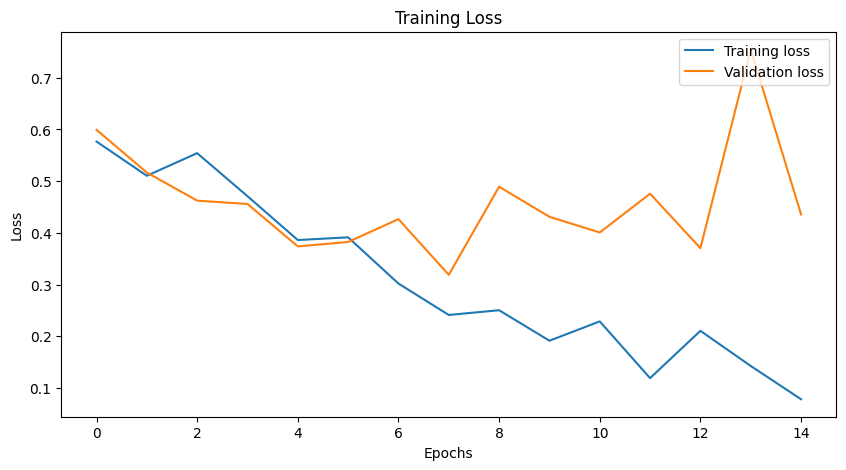

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [ ]:
def compute_accuracy(model, dataloader, device=None):
    """Compute the accuracy of the model on the given dataloader.

        Args:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): The dataloader containing the data to evaluate.
            device (torch.device, optional): The device to use for computation. Defaults to None (uses CPU).

        Returns:
            float: The accuracy of the model on the given data.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        model.cuda()

    model = model.eval()

    correct = 0.0
    total_examples = 0

    # Iterate over the data in the dataloader
    for idx, (features, labels) in enumerate(dataloader):

        features, labels = features.to(device), labels.to(device)

        # Forward pass of the model without gradient computation
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

         # Compare the predicted labels with the true labels
        compare = labels == predictions
        # Accumulate the number of correct predictions
        correct += torch.sum(compare)
        # Accumulate the total number of examples
        total_examples += len(compare)

    return correct / total_examples

In [ ]:
train_acc = compute_accuracy(cats_dogs_cnn_model, train_dataloader, device = torch.device('cuda'))
val_acc = compute_accuracy(cats_dogs_cnn_model, val_dataloader, device = torch.device('cuda'))
test_acc = compute_accuracy(cats_dogs_cnn_model, test_dataloader, device = torch.device('cuda'))
print(
    f"Train Acc {train_acc*100:.2f}%",
    f" | Val Acc {val_acc*100:.2f}%",
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 95.64%  | Val Acc 85.50%  | Test Acc 86.05%


In [ ]:
test_batch = next(iter(test_dataloader))

print(test_batch[0].shape)
print(test_batch[1])

torch.Size([25, 3, 128, 128])
tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1])


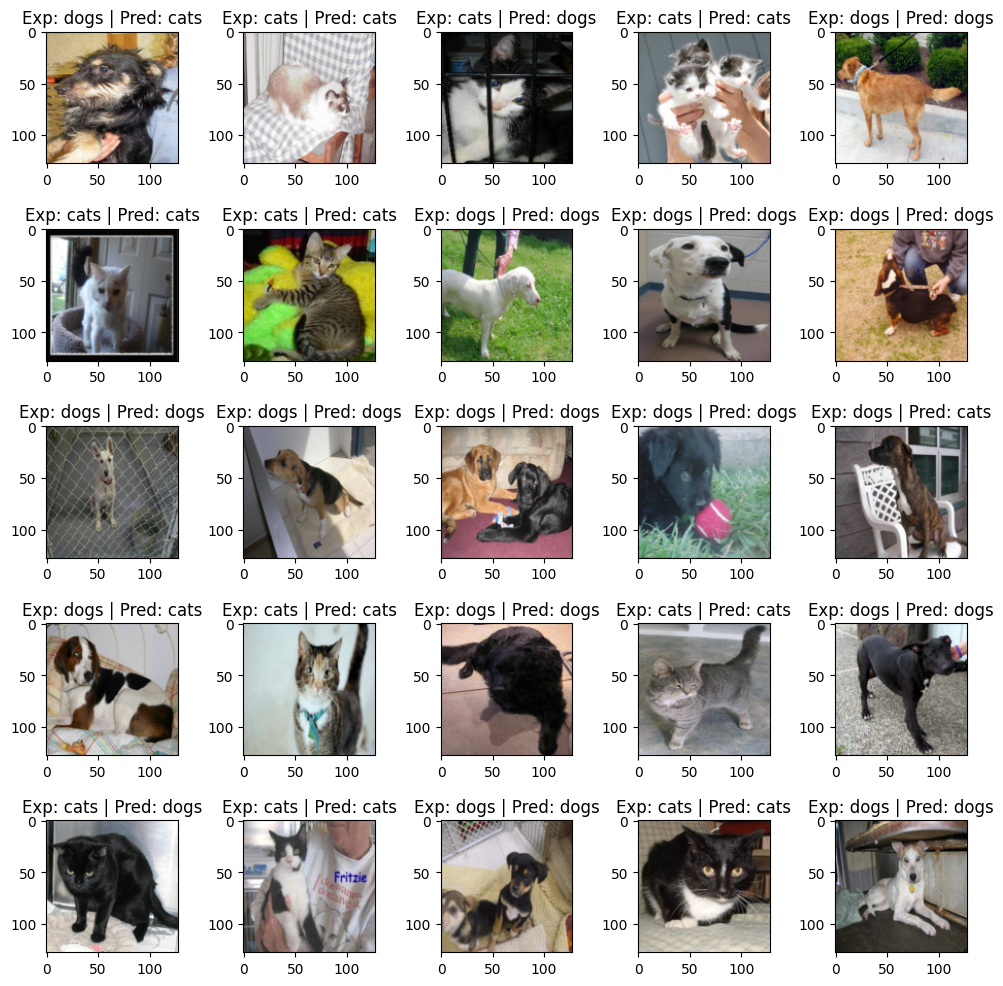

In [ ]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=1.)

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    image = test_batch[0][idx].numpy()
    # image = np.reshape(image, (150, 150, 3))
    image = image.transpose((1, 2, 0))
    image = (image * 255.0).astype("uint8")

    label = test_batch[1][idx].item()

    ax[row, col].imshow(image)

    # Reshape the test data to match the model input shape
    test_data = np.reshape(test_batch[0][idx], (1, 3, 128, 128))

    # Forward pass of the model without gradient computation
    with torch.no_grad():
        # Get the model prediction for the test data
        prediction = cats_dogs_cnn_model(test_data.cuda()).cpu()

    # Set the title of the subplot with expected and predicted labels
    ax[row, col].set_title(f'Exp: {idx_to_class[label]} | Pred: {idx_to_class[np.argmax(prediction).item()]}')
    #ax[row, col].set_title(f'{prediction}')

# Challenge

Usando el dataset de [mariposas de kaggle](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data), crea un classificador para las diferentes imágenes de mariposas.

Las siguientes líneas descargan el dataset:

In [ ]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/phucthaiv02/butterfly-image-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  225M  100  225M    0     0  19.1M      0  0:00:11  0:00:11 --:--:-- 22.2M


In [ ]:
!ls
!rm -rf butterfly
!unzip -d butterfly/ archive.zip > /dev/null

archive.zip  DL_Data_sets  logs  sample_data


In [ ]:
!ls butterfly

test  Testing_set.csv  train  Training_set.csv
